# To predict the house type based on region, size, rooms, seller, pricing and other factors

In [1]:
### Library used.
library(gbm)
library(glmnet)
library(gridExtra)
library(rpart)
library(nnet)
library(corrplot)
library(e1071)
library(Metrics)

Loaded gbm 2.1.5
Loading required package: Matrix
Warning message:
"package 'Matrix' was built under R version 3.6.3"Loading required package: foreach
Loaded glmnet 2.0-16

Warning message:
"package 'gridExtra' was built under R version 3.6.3"Warning message:
"package 'nnet' was built under R version 3.6.3"corrplot 0.92 loaded
Warning message:
"package 'e1071' was built under R version 3.6.3"Warning message:
"package 'Metrics' was built under R version 3.6.3"
Attaching package: 'Metrics'

The following object is masked from 'package:glmnet':

    auc



In [1]:
### Reading data set in csv file.###

data = read.csv("E:/New folder/Melbourne_housing_FULL.csv")
head(data)
str(data)
dim(data)

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,⋯,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
,<chr>,<chr>,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<int>,<int>,<int>,<dbl>,<int>,<chr>,<dbl>,<dbl>,<chr>,<chr>
1,Abbotsford,68 Studley St,2,h,NA,SS,Jellis,3/09/2016,2.5,3067,⋯,1,1,126,NA,NA,Yarra City Council,-37.8014,144.9958,Northern Metropolitan,4019
2,Abbotsford,85 Turner St,2,h,1480000,S,Biggin,3/12/2016,2.5,3067,⋯,1,1,202,NA,NA,Yarra City Council,-37.7996,144.9984,Northern Metropolitan,4019
3,Abbotsford,25 Bloomburg St,2,h,1035000,S,Biggin,4/02/2016,2.5,3067,⋯,1,0,156,79,1900,Yarra City Council,-37.8079,144.9934,Northern Metropolitan,4019
4,Abbotsford,18/659 Victoria St,3,u,NA,VB,Rounds,4/02/2016,2.5,3067,⋯,2,1,0,NA,NA,Yarra City Council,-37.8114,145.0116,Northern Metropolitan,4019
5,Abbotsford,5 Charles St,3,h,1465000,SP,Biggin,4/03/2017,2.5,3067,⋯,2,0,134,150,1900,Yarra City Council,-37.8093,144.9944,Northern Metropolitan,4019
6,Abbotsford,40 Federation La,3,h,850000,PI,Biggin,4/03/2017,2.5,3067,⋯,2,1,94,NA,NA,Yarra City Council,-37.7969,144.9969,Northern Metropolitan,4019


'data.frame':	34857 obs. of  21 variables:
 $ Suburb       : chr  "Abbotsford" "Abbotsford" "Abbotsford" "Abbotsford" ...
 $ Address      : chr  "68 Studley St" "85 Turner St" "25 Bloomburg St" "18/659 Victoria St" ...
 $ Rooms        : int  2 2 2 3 3 3 4 4 2 2 ...
 $ Type         : chr  "h" "h" "h" "u" ...
 $ Price        : int  NA 1480000 1035000 NA 1465000 850000 1600000 NA NA NA ...
 $ Method       : chr  "SS" "S" "S" "VB" ...
 $ SellerG      : chr  "Jellis" "Biggin" "Biggin" "Rounds" ...
 $ Date         : chr  "3/09/2016" "3/12/2016" "4/02/2016" "4/02/2016" ...
 $ Distance     : chr  "2.5" "2.5" "2.5" "2.5" ...
 $ Postcode     : chr  "3067" "3067" "3067" "3067" ...
 $ Bedroom2     : int  2 2 2 3 3 3 3 3 4 3 ...
 $ Bathroom     : int  1 1 1 2 2 2 1 2 1 2 ...
 $ Car          : int  1 1 0 1 0 1 2 2 2 1 ...
 $ Landsize     : int  126 202 156 0 134 94 120 400 201 202 ...
 $ BuildingArea : num  NA NA 79 NA 150 NA 142 220 NA NA ...
 $ YearBuilt    : int  NA NA 1900 NA 1900 NA 2014 2006 1

[1] 34857    21

In [3]:
#Cheking the presence of Null Values.

sapply(data, function(x) sum(is.na(x)))

Suburb       Address         Rooms          Type         Price 
            0             0             0             0          7610 
       Method       SellerG          Date      Distance      Postcode 
            0             0             0             0             0 
     Bedroom2      Bathroom           Car      Landsize  BuildingArea 
         8217          8226          8728         11810         21115 
    YearBuilt   CouncilArea     Lattitude    Longtitude    Regionname 
        19306             0          7976          7976             0 
Propertycount 
            0

#We are removing columns with large number of NAN Values and unique nominal values.

Address : It contains unique values
Building Area : It contains nearly 50% Nan values
Year Built : It contains nearly 50% Nan values
Council Area : It contains more dan 100 nominal values
Suburb : It contains more dan 100 nominal values
SellerG : It contains more than 100 nominal values

In [4]:
###Removing unnecessary columns. ###

cols_to_be_removed=c("Address","BuildingArea","YearBuilt","CouncilArea","Address","SellerG")
data = data[,!(names(data) %in% cols_to_be_removed) ]
sapply(data, function(x) sum(is.na(x)))

Suburb         Rooms          Type         Price        Method 
            0             0             0          7610             0 
         Date      Distance      Postcode      Bedroom2      Bathroom 
            0             0             0          8217          8226 
          Car      Landsize     Lattitude    Longtitude    Regionname 
         8728         11810          7976          7976             0 
Propertycount 
            0

Following columns with missing values are replaced with mean values for better results.
Price
Bathroom
Bedroom2
Landsize

In [5]:
### Missing values are replaced with mean values. ####

data$Bathroom[is.na(data$Bathroom)]<-mean(data$Bathroom,na.rm=TRUE)
data$Bedroom2[is.na(data$Bedroom2)]<-mean(data$Bedroom2,na.rm=TRUE)
data$Price[is.na(data$Price)]<-mean(data$Price,na.rm=TRUE)
data$Landsize[is.na(data$Landsize)]<-mean(data$Landsize,na.rm=TRUE)
data$Lattitude[is.na(data$Lattitude)]<-mean(data$Lattitude,na.rm=TRUE)
data$Longtitude[is.na(data$Longtitude)]<-mean(data$Longtitude,na.rm=TRUE)
data

Suburb,Rooms,Type,Price,Method,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,Lattitude,Longtitude,Regionname,Propertycount
Abbotsford,2,h,1050173,SS,3/09/2016,2.5,3067,2.000000,1.000000,1,126.000,-37.80140,144.9958,Northern Metropolitan,4019
Abbotsford,2,h,1480000,S,3/12/2016,2.5,3067,2.000000,1.000000,1,202.000,-37.79960,144.9984,Northern Metropolitan,4019
Abbotsford,2,h,1035000,S,4/02/2016,2.5,3067,2.000000,1.000000,0,156.000,-37.80790,144.9934,Northern Metropolitan,4019
Abbotsford,3,u,1050173,VB,4/02/2016,2.5,3067,3.000000,2.000000,1,0.000,-37.81140,145.0116,Northern Metropolitan,4019
Abbotsford,3,h,1465000,SP,4/03/2017,2.5,3067,3.000000,2.000000,0,134.000,-37.80930,144.9944,Northern Metropolitan,4019
Abbotsford,3,h,850000,PI,4/03/2017,2.5,3067,3.000000,2.000000,1,94.000,-37.79690,144.9969,Northern Metropolitan,4019
Abbotsford,4,h,1600000,VB,4/06/2016,2.5,3067,3.000000,1.000000,2,120.000,-37.80720,144.9941,Northern Metropolitan,4019
Abbotsford,4,h,1050173,SN,6/08/2016,2.5,3067,3.000000,2.000000,2,400.000,-37.79650,144.9965,Northern Metropolitan,4019
Abbotsford,2,h,1050173,S,6/08/2016,2.5,3067,4.000000,1.000000,2,201.000,-37.79950,144.9974,Northern Metropolitan,4019
Abbotsford,2,h,1050173,S,6/08/2016,2.5,3067,3.000000,2.000000,1,202.000,-37.79960,144.9989,Northern Metropolitan,4019


In [6]:
sapply(data, function(x) sum(is.na(x)))

Suburb         Rooms          Type         Price        Method 
            0             0             0             0             0 
         Date      Distance      Postcode      Bedroom2      Bathroom 
            0             0             0             0             0 
          Car      Landsize     Lattitude    Longtitude    Regionname 
         8728             0             0             0             0 
Propertycount 
            0

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  0.000   1.000   2.000   1.673   2.000   3.500    8728 

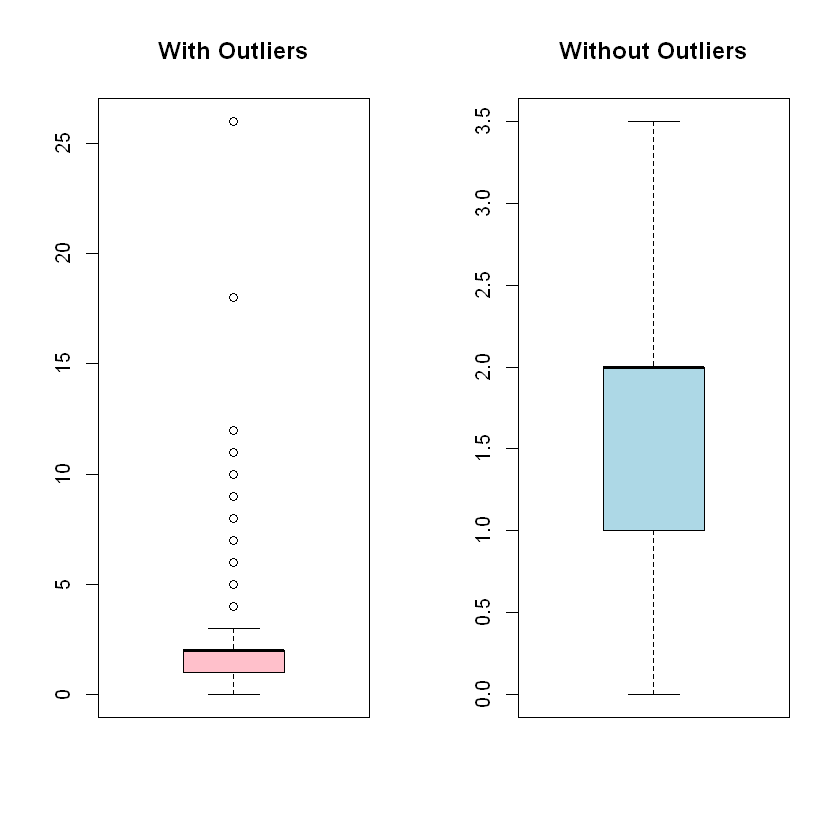

In [7]:
### Outlier Anaysis for Attribute - Car. ###

par(mfrow=c(1,2))
boxplot(data$Car, col = "pink", main="With Outliers") #Attribute with Outliers
#Removing outliers in Car attribute
p75 = quantile(data$Car,0.75, na.rm = TRUE)
p25 = quantile(data$Car,0.25, na.rm = TRUE)
# print(p75)
# print(p25)
iqr = p75-p25
# print(head(is.na(data$Car)))
data$Car = ifelse(data$Car<p25-1.5*iqr,ave(data$Car, FUN = function(x) p25-1.5*iqr),data$Car)
data$Car = ifelse(data$Car>p75+1.5*iqr,ave(data$Car, FUN = function(x) p75+1.5*iqr),data$Car)
boxplot(data$Car, col ="lightblue", main="Without Outliers") # Attribute without outliers
summary(data$Car)

In [8]:
data$Car[is.na(data$Car)]<-mean(data$Car,na.rm=TRUE)
sapply(data, function(x) sum(is.na(x)))
# Null values removed from car table by placing mean values in the missing one.

Suburb         Rooms          Type         Price        Method 
            0             0             0             0             0 
         Date      Distance      Postcode      Bedroom2      Bathroom 
            0             0             0             0             0 
          Car      Landsize     Lattitude    Longtitude    Regionname 
            0             0             0             0             0 
Propertycount 
            0

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   1.000   1.673   1.673   2.000   3.500 

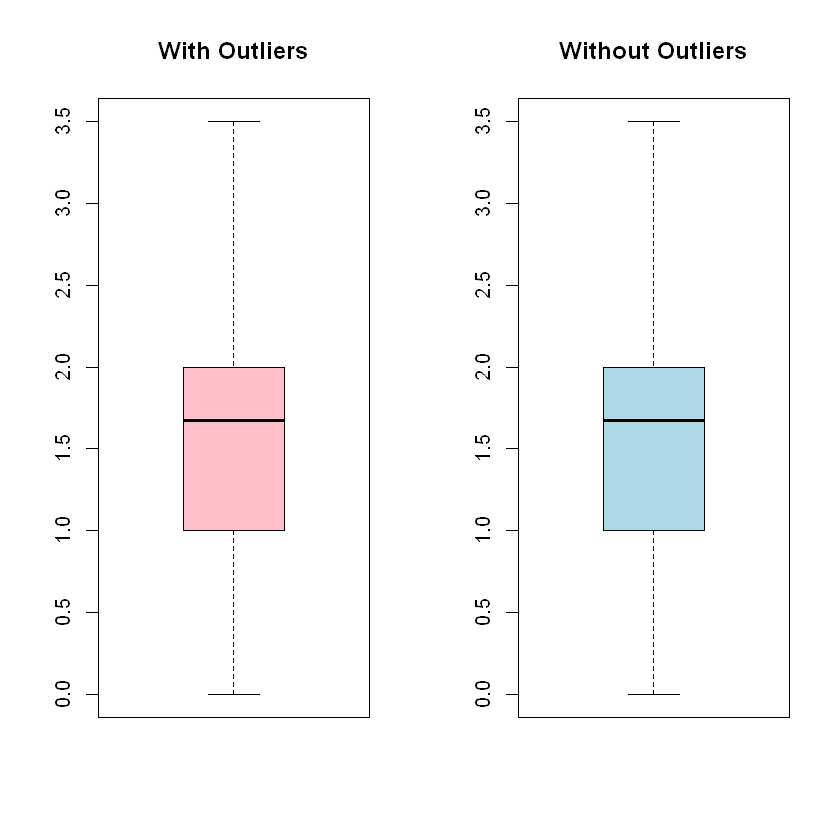

In [9]:
### Outlier Anaysis for Attribute - Car and replaced with mean values. ###
par(mfrow=c(1,2))
boxplot(data$Car, col = "pink", main="With Outliers") #Attribute with Outliers
#Removing outliers in Car attribute
p75 = quantile(data$Car,0.75, na.rm = TRUE)
p25 = quantile(data$Car,0.25, na.rm = TRUE)
# print(p75)
# print(p25)
iqr = p75-p25
# print(head(is.na(data$Car)))
data$Car = ifelse(data$Car<p25-1.5*iqr,ave(data$Car, FUN = function(x) p25-1.5*iqr),data$Car)
data$Car = ifelse(data$Car>p75+1.5*iqr,ave(data$Car, FUN = function(x) p75+1.5*iqr),data$Car)
boxplot(data$Car, col ="lightblue", main="Without Outliers") # Attribute without outliers
summary(data$Car)

In [10]:
print(mean(data$Car, na.rm=TRUE))
data$Car = ifelse(is.na(data$Car),ave(data$Car, FUN = function(x) mean(x, na.rm=TRUE)),data$Car)

[1] 1.672816


Removing the outliers in Rooms Column

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   2.000   3.000   3.029   4.000   7.000 

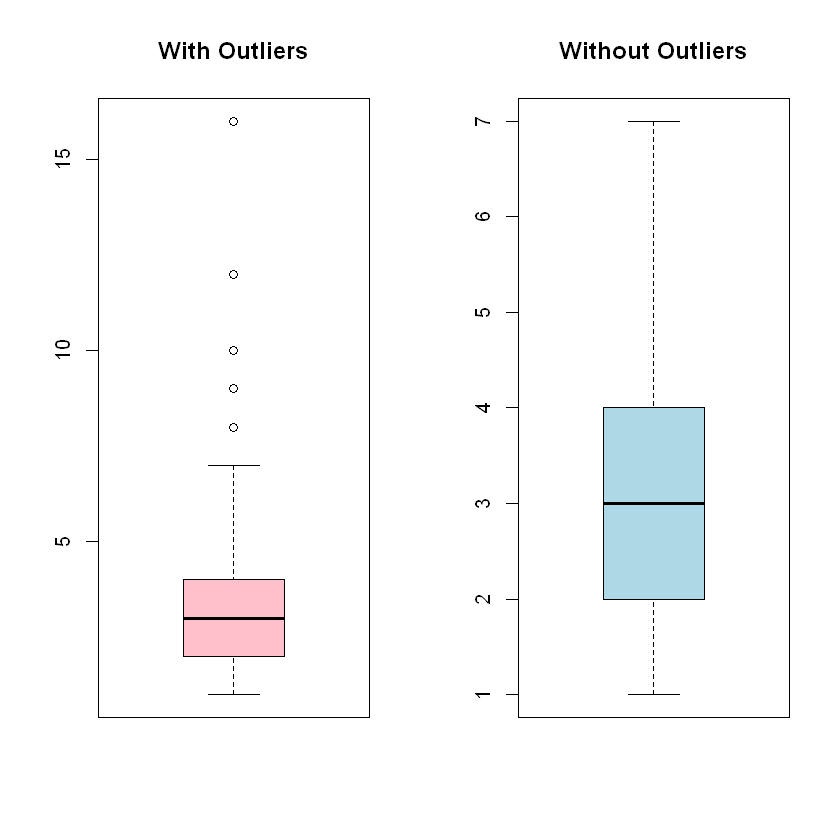

In [11]:
### Outlier Anaysis for Attribute - Rooms and replaced with mean values. ###
par(mfrow=c(1,2))
boxplot(data$Rooms, col = "pink", main="With Outliers") #Attribute with Outliers
#Removing outliers in Rooms attribute
p75 = quantile(data$Rooms,0.75, na.rm = TRUE)
p25 = quantile(data$Rooms,0.25, na.rm = TRUE)
# print(p75)
# print(p25)
iqr = p75-p25
# print(head(is.na(data$Car)))
data$Rooms = ifelse(data$Rooms<p25-1.5*iqr,ave(data$Rooms, FUN = function(x) p25-1.5*iqr),data$Rooms)
data$Rooms = ifelse(data$Rooms>p75+1.5*iqr,ave(data$Rooms, FUN = function(x) p75+1.5*iqr),data$Rooms)
boxplot(data$Rooms, col ="lightblue", main="Without Outliers") # Attribute without outliers
summary(data$Rooms)                                               

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  85000  695000 1050173  998659 1150000 1832500 

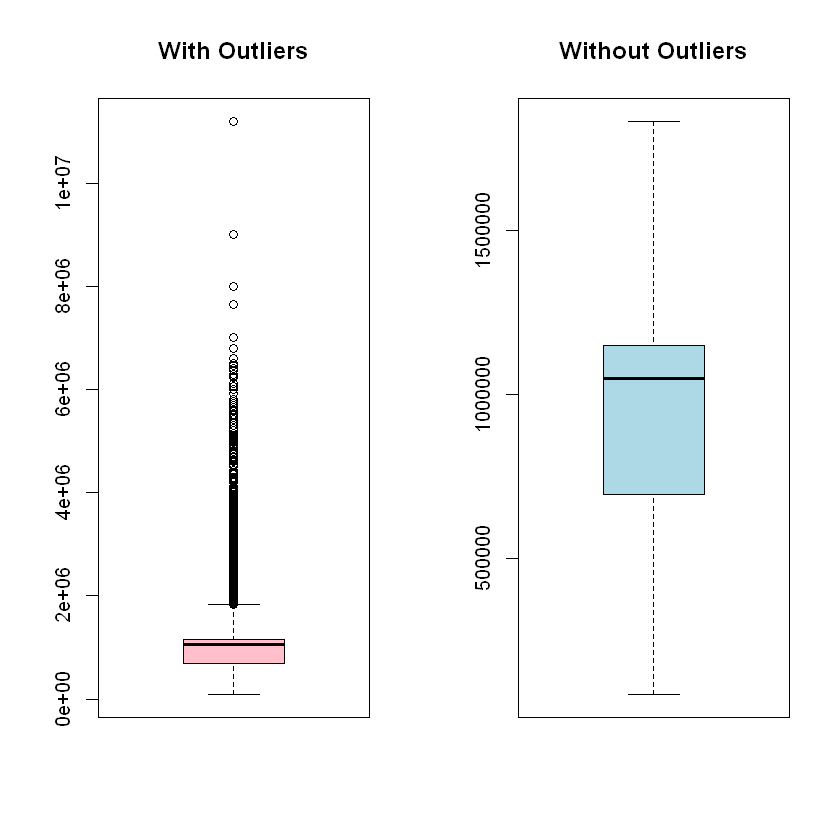

In [12]:
### Outlier Anaysis for Attribute - Price and replaced with mean values. ###
par(mfrow=c(1,2))
boxplot(data$Price, col = "pink", main="With Outliers") #Attribute with Outliers
#Removing outliers in Price attribute
p75 = quantile(data$Price,0.75, na.rm = TRUE)
p25 = quantile(data$Price,0.25, na.rm = TRUE)
# print(p75)
# print(p25)
iqr = p75-p25
# print(head(is.na(data$Car)))
data$Price = ifelse(data$Price<p25-1.5*iqr,ave(data$Price, FUN = function(x) p25-1.5*iqr),data$Price)
data$Price = ifelse(data$Price>p75+1.5*iqr,ave(data$Price, FUN = function(x) p75+1.5*iqr),data$Price)
boxplot(data$Price, col ="lightblue", main="Without Outliers") # Attribute without outliers
summary(data$Price)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    1.0    43.0    90.0   108.1   183.0   216.0 

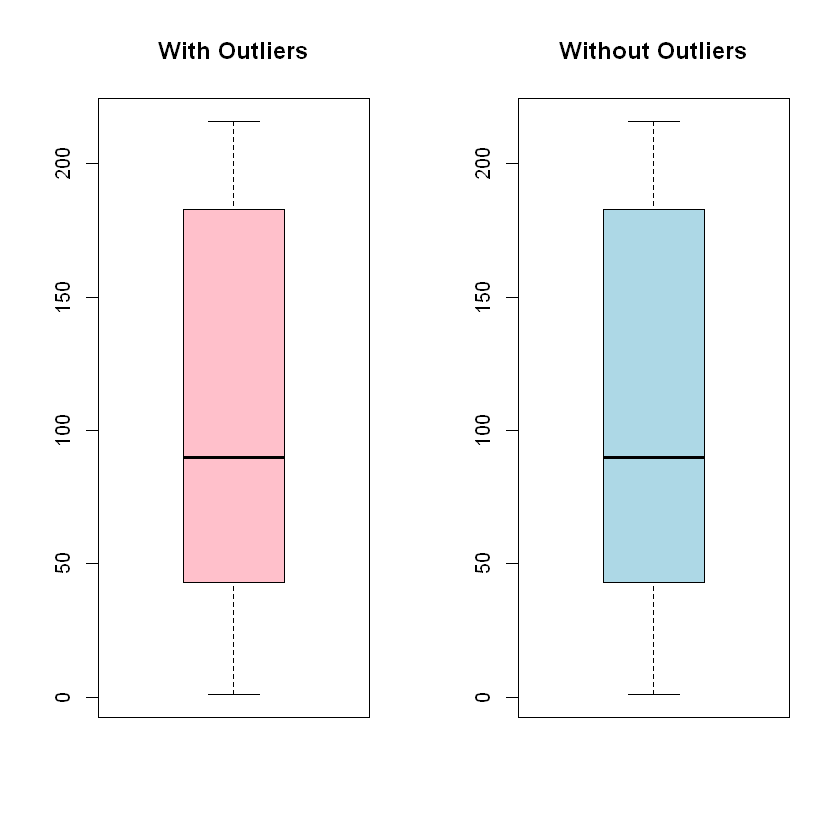

In [13]:
### Outlier Anaysis for Attribute - Distance  and replaced with mean values. 

data$Distance <- as.numeric(data$Distance)                   
par(mfrow=c(1,2))
boxplot.default(data$Distance, col = "pink", main="With Outliers") #Attribute with Outliers
#Removing outliers in Distance attribute
p75 = quantile(data$Distance,0.75, na.rm = TRUE)
p25 = quantile(data$Distance,0.25, na.rm = TRUE)
# print(p75)
# print(p25)
iqr = p75-p25
# print(head(is.na(data$Car)))
data$Distance = ifelse(data$Distance<p25-1.5*iqr,ave(data$Distance, FUN = function(x) p25-1.5*iqr),data$Distance)
data$Distance = ifelse(data$Distance>p75+1.5*iqr,ave(data$Distance, FUN = function(x) p75+1.5*iqr),data$Distance)
boxplot(data$Distance, col ="lightblue", main="Without Outliers") # Attribute without outliers
summary(data$Distance)                                                    

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.0   357.0   593.6   508.5   598.0   959.5 

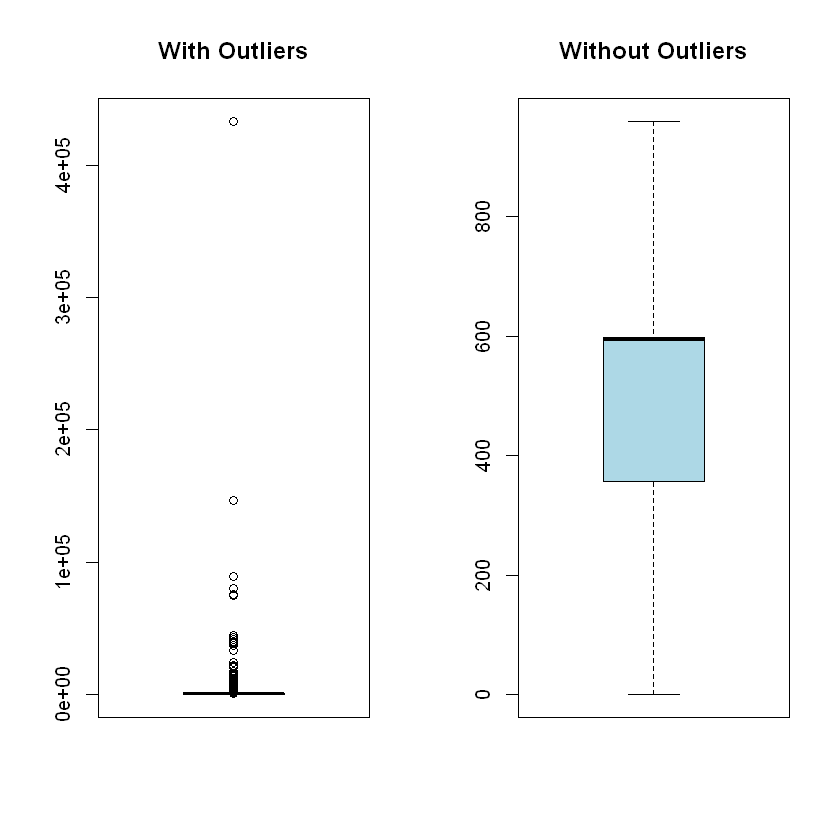

In [14]:
### Outlier Anaysis for Attribute - Landsize and replaced with mean values. ###

par(mfrow=c(1,2))
boxplot(data$Landsize, col = "pink", main="With Outliers") #Attribute with Outliers
#Removing outliers in Landsize attribute
p75 = quantile(data$Landsize,0.75, na.rm = TRUE)
p25 = quantile(data$Landsize,0.25, na.rm = TRUE)
# print(p75)
# print(p25)
iqr = p75-p25
# print(head(is.na(data$Car)))
data$Landsize = ifelse(data$Landsize<p25-1.5*iqr,ave(data$Landsize, FUN = function(x) p25-1.5*iqr),data$Landsize)
data$Landsize = ifelse(data$Landsize>p75+1.5*iqr,ave(data$Landsize, FUN = function(x) p75+1.5*iqr),data$Landsize)
boxplot(data$Landsize, col ="lightblue", main="Without Outliers") # Attribute without outliers
summary(data$Landsize)                                                    

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   1.000   1.625   1.615   2.000   3.500 

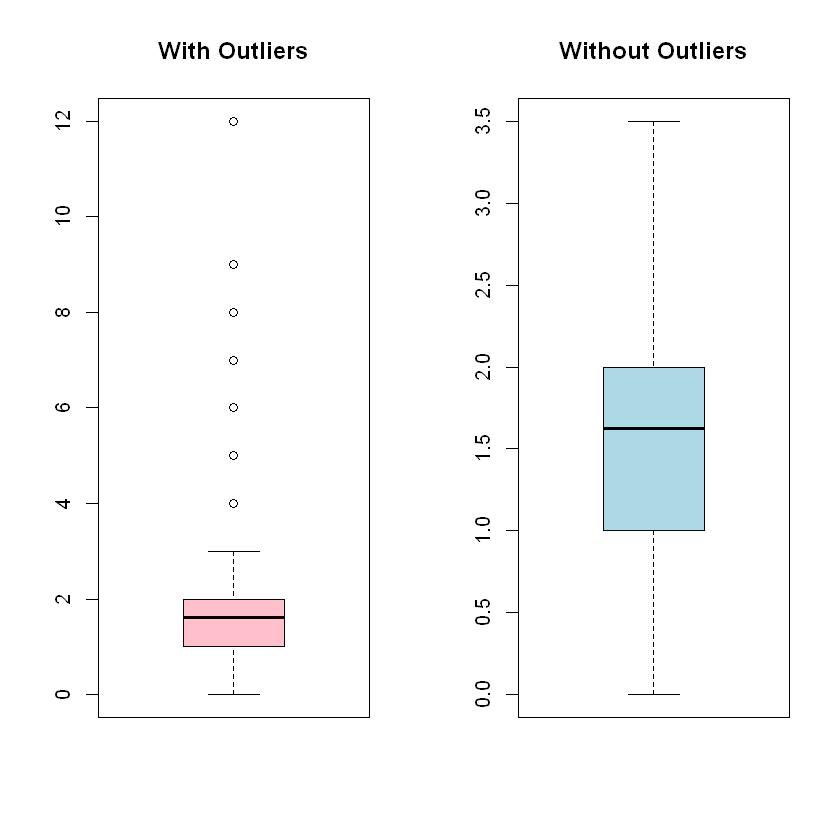

In [15]:
### Outlier Anaysis for Attribute - Bathroom and replaced with mean values. ###

par(mfrow=c(1,2))
boxplot(data$Bathroom, col = "pink", main="With Outliers") #Attribute with Outliers
#Removing outliers in Bathroom attribute
p75 = quantile(data$Bathroom,0.75, na.rm = TRUE)
p25 = quantile(data$Bathroom,0.25, na.rm = TRUE)
# print(p75)
# print(p25)
iqr = p75-p25
# print(head(is.na(data$Car)))
data$Bathroom = ifelse(data$Bathroom<p25-1.5*iqr,ave(data$Bathroom, FUN = function(x) p25-1.5*iqr),data$Bathroom)
data$Bathroom = ifelse(data$Bathroom>p75+1.5*iqr,ave(data$Bathroom, FUN = function(x) p75+1.5*iqr),data$Bathroom)
boxplot(data$Bathroom, col ="lightblue", main="Without Outliers") # Attribute without outliers
summary(data$Bathroom)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  2.873   3.000   3.000   3.044   3.085   3.212 

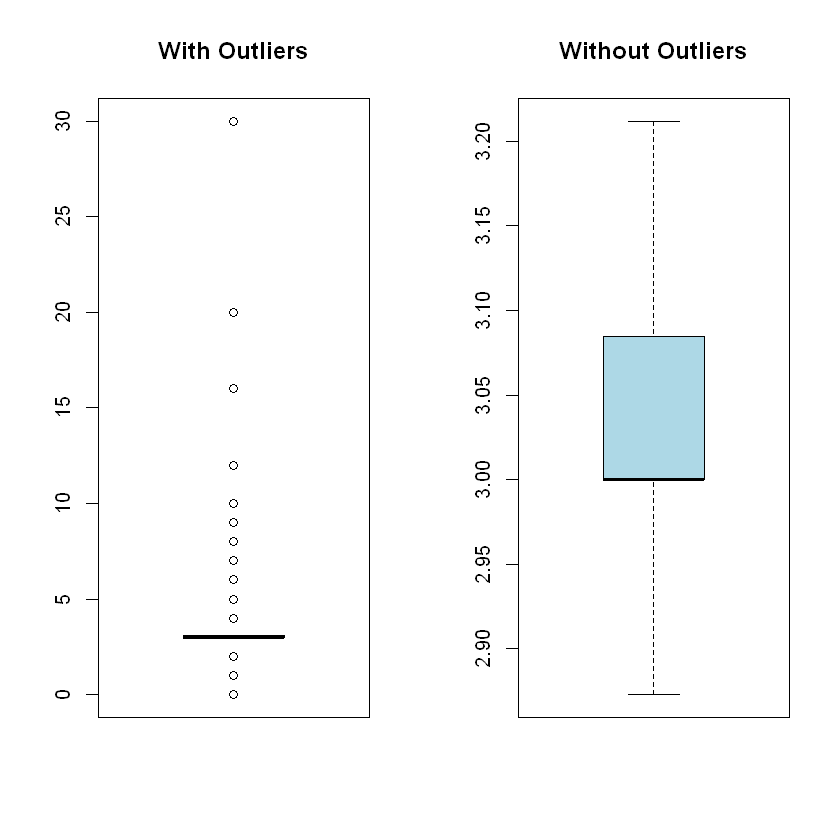

In [16]:
### Outlier Anaysis for Attribute - Bedroom2 and replaced with mean values. ###

par(mfrow=c(1,2))
boxplot(data$Bedroom2, col = "pink", main="With Outliers") #Attribute with Outliers
#Removing outliers in Bathroom attribute
p75 = quantile(data$Bedroom2,0.75, na.rm = TRUE)
p25 = quantile(data$Bedroom2,0.25, na.rm = TRUE)
# print(p75)
# print(p25)
iqr = p75-p25
# print(head(is.na(data$Car)))
data$Bedroom2 = ifelse(data$Bedroom2<p25-1.5*iqr,ave(data$Bedroom2, FUN = function(x) p25-1.5*iqr),data$Bedroom2)
data$Bedroom2 = ifelse(data$Bedroom2>p75+1.5*iqr,ave(data$Bedroom2, FUN = function(x) p75+1.5*iqr),data$Bedroom2)
boxplot(data$Bedroom2, col ="lightblue", main="Without Outliers") # Attribute without outliers
summary(data$Bedroom2)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    1.0    62.0   200.0   177.3   273.0   343.0 

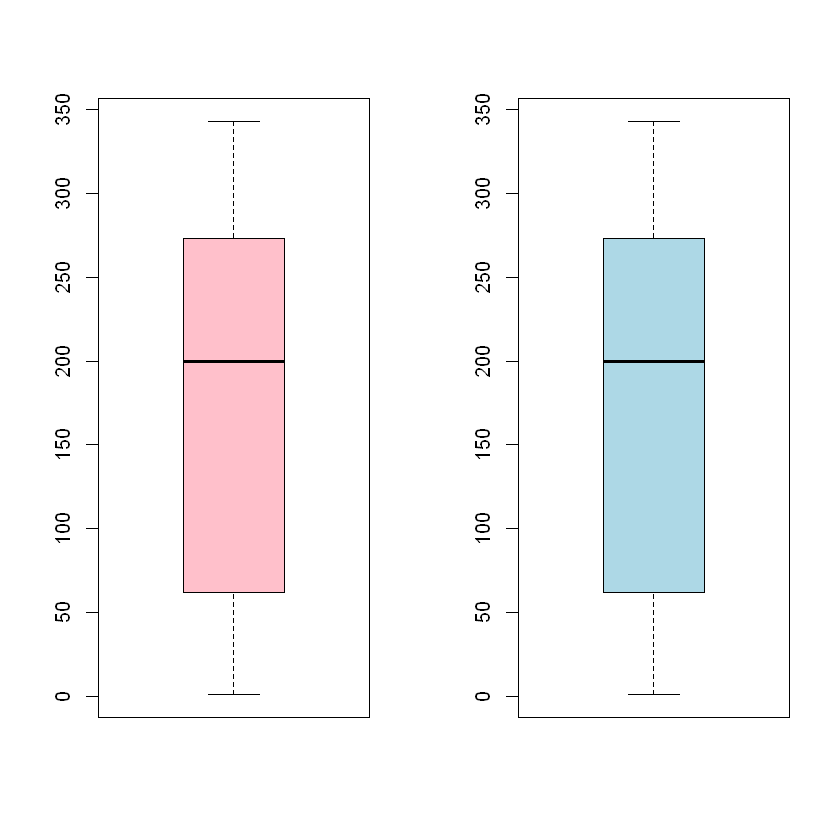

In [17]:
### Outlier Anaysis for Attribute - Propercount and replaced with mean values. ###

data$Propertycount <- as.numeric(data$Propertycount)
par(mfrow=c(1,2))
boxplot(data$Propertycount, col = "pink", title="With Outliers") #Attribute with Outliers
#Removing outliers in Bathroom attribute
p75 = quantile(data$Propertycount,0.75, na.rm = TRUE)
p25 = quantile(data$Propertycount,0.25, na.rm = TRUE)
# print(p75)
# print(p25)
iqr = p75-p25
# print(head(is.na(data$Car)))
data$Propertycount = ifelse(data$Propertycount<p25-1.5*iqr,ave(data$Propertycount, FUN = function(x) p25-1.5*iqr),data$Propertycount)
data$Propertycount = ifelse(data$Propertycount>p75+1.5*iqr,ave(data$Propertycount, FUN = function(x) p75+1.5*iqr),data$Propertycount)
boxplot(data$Propertycount, col ="lightblue", title="Without Outliers") # Attribute without outliers
summary(data$Propertycount)                                                               

# Pie chart of House Type in Melbourne

In [18]:
typeAtr = subset(data, select = c(Type))
data = subset(data, select = -c(Type))

Warning message in text.default(1.1 * P$x, 1.1 * P$y, labels[i], xpd = TRUE, adj = ifelse(P$x < :
""explode" is not a graphical parameter"Warning message in text.default(1.1 * P$x, 1.1 * P$y, labels[i], xpd = TRUE, adj = ifelse(P$x < :
""explode" is not a graphical parameter"Warning message in text.default(1.1 * P$x, 1.1 * P$y, labels[i], xpd = TRUE, adj = ifelse(P$x < :
""explode" is not a graphical parameter"Warning message in title(main = main, ...):
""explode" is not a graphical parameter"

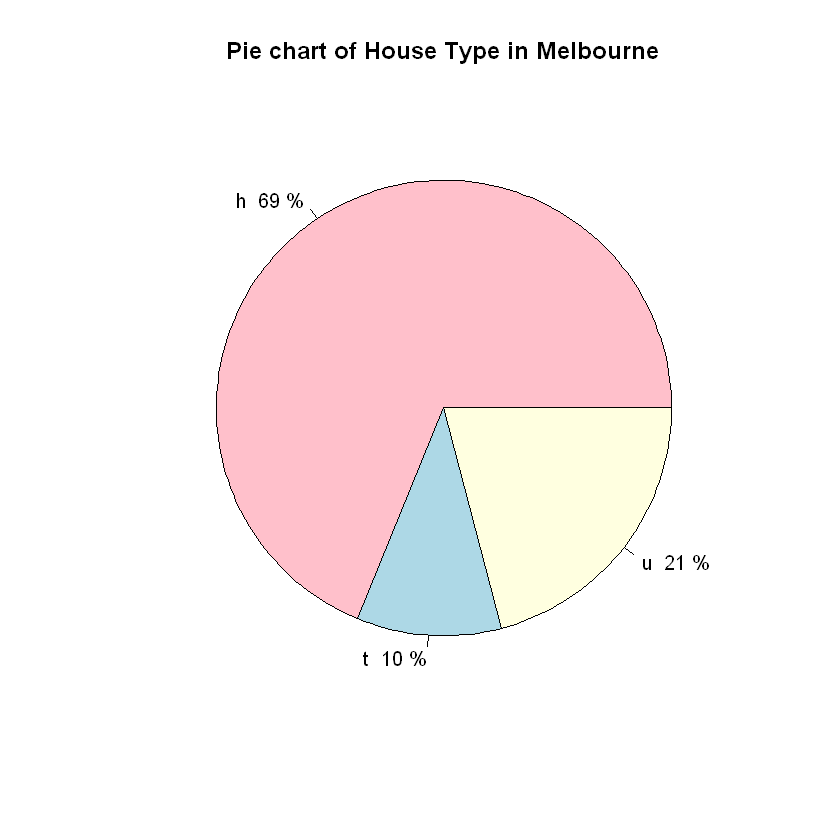

In [19]:
y = typeAtr
pct = round((table(y)/sum(table(y)))*100)
lbs = paste(c("h","t","u"),"",pct,"%",sep=" ")
pie(table(y), labels=lbs,main="Pie chart of House Type in Melbourne",
col=c("pink", "lightblue", "lightyellow"),explode=0.1)

Ordinal Encoding for the Target Variable Type

In [20]:
#Converting Type attribute into numeric data type and labelling attributes into 1,2 and 3.
typeAtr = factor(typeAtr$Type,levels = c('h','u','t'), labels = c(1,2,3))
typeAtr = as.numeric(typeAtr)
print(class(typeAtr))
data = cbind(data,data.frame(Type=typeAtr))

[1] "numeric"


In [21]:
### Reviewing data. ###

class(data)
names(data)
str(data)

[1] "data.frame"

[1] "Suburb"        "Rooms"         "Price"         "Method"       
 [5] "Date"          "Distance"      "Postcode"      "Bedroom2"     
 [9] "Bathroom"      "Car"           "Landsize"      "Lattitude"    
[13] "Longtitude"    "Regionname"    "Propertycount" "Type"

'data.frame':	34857 obs. of  16 variables:
 $ Suburb       : Factor w/ 351 levels "Abbotsford","Aberfeldie",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ Rooms        : num  2 2 2 3 3 3 4 4 2 2 ...
 $ Price        : num  1050173 1480000 1035000 1050173 1465000 ...
 $ Method       : Factor w/ 9 levels "PI","PN","S",..: 7 3 3 8 6 1 8 5 3 3 ...
 $ Date         : Factor w/ 78 levels "1/07/2017","10/02/2018",..: 59 61 64 64 65 65 66 70 70 70 ...
 $ Distance     : num  82 82 82 82 82 82 82 82 82 82 ...
 $ Postcode     : Factor w/ 212 levels "#N/A","3000",..: 55 55 55 55 55 55 55 55 55 55 ...
 $ Bedroom2     : num  2.87 2.87 2.87 3 3 ...
 $ Bathroom     : num  1 1 1 2 2 2 1 2 1 2 ...
 $ Car          : num  1 1 0 1 0 1 2 2 2 1 ...
 $ Landsize     : num  126 202 156 0 134 94 120 400 201 202 ...
 $ Lattitude    : num  -37.8 -37.8 -37.8 -37.8 -37.8 ...
 $ Longtitude   : num  145 145 145 145 145 ...
 $ Regionname   : Factor w/ 9 levels "#N/A","Eastern Metropolitan",..: 4 4 4 4 4 4 4 4 4 4 ...
 $ Propertycount: n

In [22]:
# checking the format of the date
mydate = data$Date
head(mydate)

[1] 3/09/2016 3/12/2016 4/02/2016 4/02/2016 4/03/2017 4/03/2017
78 Levels: 1/07/2017 10/02/2018 10/03/2018 10/09/2016 10/12/2016 ... 9/12/2017

In [23]:
#Converting the date into the desired format. ###

head(as.Date(mydate,format="%d/%m/%Y"))

[1] "2016-09-03" "2016-12-03" "2016-02-04" "2016-02-04" "2017-03-04"
[6] "2017-03-04"

In [24]:
# Splitting the Date into day, month and year.###

datetxt <- data$Date
datetxt <- as.Date(datetxt,format="%d/%m/%Y")
df <- data.frame(day = as.numeric(format(datetxt, format = "%d")),
                 month = as.numeric(format(datetxt, format = "%m")),
                 year = as.numeric(format(datetxt, format = "%Y")))
head(df)
data = cbind(df,subset(data,select = -c(Date)))
head(data)

day,month,year
3,9,2016
3,12,2016
4,2,2016
4,2,2016
4,3,2017
4,3,2017


day,month,year,Suburb,Rooms,Price,Method,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,Lattitude,Longtitude,Regionname,Propertycount,Type
3,9,2016,Abbotsford,2,1050173,SS,82,3067,2.873029,1,1,126,-37.8014,144.9958,Northern Metropolitan,191,1
3,12,2016,Abbotsford,2,1480000,S,82,3067,2.873029,1,1,202,-37.7996,144.9984,Northern Metropolitan,191,1
4,2,2016,Abbotsford,2,1035000,S,82,3067,2.873029,1,0,156,-37.8079,144.9934,Northern Metropolitan,191,1
4,2,2016,Abbotsford,3,1050173,VB,82,3067,3.000000,2,1,0,-37.8114,145.0116,Northern Metropolitan,191,2
4,3,2017,Abbotsford,3,1465000,SP,82,3067,3.000000,2,0,134,-37.8093,144.9944,Northern Metropolitan,191,1
4,3,2017,Abbotsford,3,850000,PI,82,3067,3.000000,2,1,94,-37.7969,144.9969,Northern Metropolitan,191,1


In [25]:
# Find the frequency of date, month and year. ###

print(table(data$day))
print(table(data$month))
print(table(data$year))


   1    3    4    6    7    8    9   10   11   12   13   14   15   16   17   18 
 482 3024 1047 1281 1318 1266 1525 1419  926 1097  654 1000  887 1282 2496 1820 
  19   20   21   22   23   24   25   26   27   28   29   30 
 953  476  658 1304  911 1925 1457  846 1714 1966  830  293 

   1    2    3    4    5    6    7    8    9   10   11   12 
 821 2642 3094 1520 3416 3175 2959 2888 4128 3900 4387 1927 

 2016  2017  2018 
10292 19852  4713 


# Frequency barplot for Years vs Houses Sold

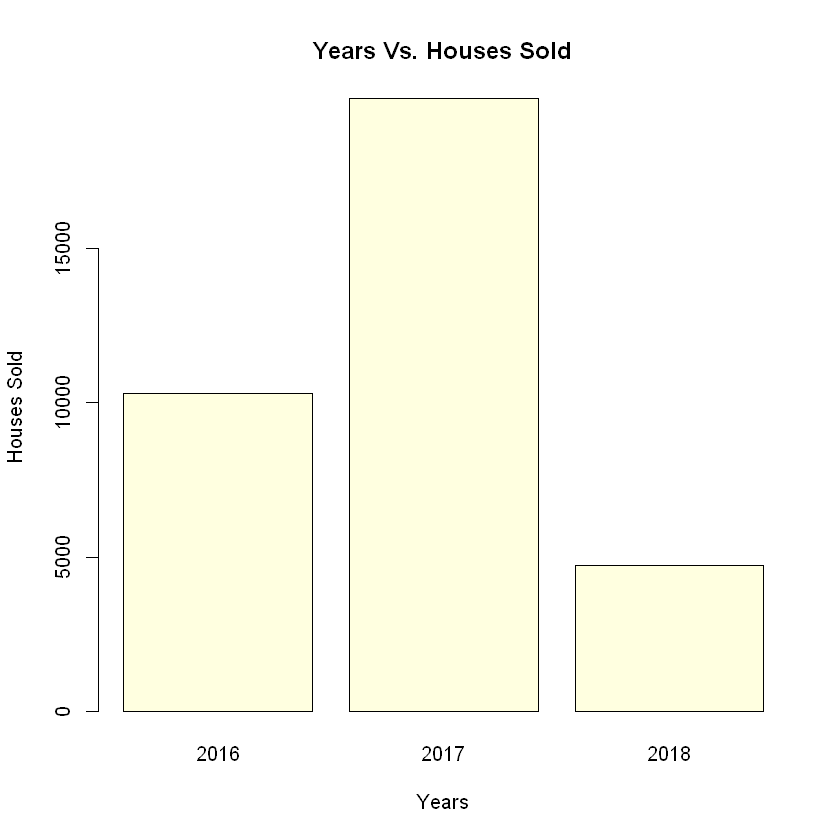

In [26]:
barplot(table(data$year), main="Years Vs. Houses Sold", col="lightyellow",xlab = "Years", ylab="Houses Sold")

# Scaling the Data (Inorder to decrease spread) = Z = x - µ / σ


In [27]:
#Scaling the data numeric values. ###

class(data)
names(data)
data$Price = as.numeric(scale(data$Price))
data$Distance = as.numeric(scale(data$Distance))
data$Landsize = as.numeric(scale(data$Landsize))
data$Propertycount = as.numeric(scale(data$Propertycount))
data$Postcode = as.numeric(data$Postcode)
data$Lattitude = as.numeric(data$Lattitude)
data$Longtitude = as.numeric(data$Longtitude)

[1] "data.frame"

[1] "day"           "month"         "year"          "Suburb"       
 [5] "Rooms"         "Price"         "Method"        "Distance"     
 [9] "Postcode"      "Bedroom2"      "Bathroom"      "Car"          
[13] "Landsize"      "Lattitude"     "Longtitude"    "Regionname"   
[17] "Propertycount" "Type"

In [28]:
str(data)

'data.frame':	34857 obs. of  18 variables:
 $ day          : num  3 3 4 4 4 4 4 6 6 6 ...
 $ month        : num  9 12 2 2 3 3 6 8 8 8 ...
 $ year         : num  2016 2016 2016 2016 2017 ...
 $ Suburb       : Factor w/ 351 levels "Abbotsford","Aberfeldie",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ Rooms        : num  2 2 2 3 3 3 4 4 2 2 ...
 $ Price        : num  0.1312 1.2258 0.0925 0.1312 1.1876 ...
 $ Method       : Factor w/ 9 levels "PI","PN","S",..: 7 3 3 8 6 1 8 5 3 3 ...
 $ Distance     : num  -0.367 -0.367 -0.367 -0.367 -0.367 ...
 $ Postcode     : num  55 55 55 55 55 55 55 55 55 55 ...
 $ Bedroom2     : num  2.87 2.87 2.87 3 3 ...
 $ Bathroom     : num  1 1 1 2 2 2 1 2 1 2 ...
 $ Car          : num  1 1 0 1 0 1 2 2 2 1 ...
 $ Landsize     : num  -1.62 -1.3 -1.49 -2.15 -1.59 ...
 $ Lattitude    : num  -37.8 -37.8 -37.8 -37.8 -37.8 ...
 $ Longtitude   : num  145 145 145 145 145 ...
 $ Regionname   : Factor w/ 9 levels "#N/A","Eastern Metropolitan",..: 4 4 4 4 4 4 4 4 4 4 ...
 $ Propertycoun

In [29]:
#Reming columns of Suburb and Regionname.
cols_to_be_removed=c("Suburb","Regionname")
data = data[,!(names(data) %in% cols_to_be_removed) ]
sapply(data, function(x) sum(is.na(x)))

day         month          year         Rooms         Price 
            0             0             0             0             0 
       Method      Distance      Postcode      Bedroom2      Bathroom 
            0             0             0             0             0 
          Car      Landsize     Lattitude    Longtitude Propertycount 
            0             0             0             0             0 
         Type 
            0

# Performing One Hot Encoding for the categorical nominal variables


In [30]:
#converting method into numeric. ###

mel4 <- data
mel4$Method = as.character(mel4$Method)
mel4$Method[mel4$Method == 'PI'] <- 1
mel4$Method[mel4$Method == 'PN'] <- 2
mel4$Method[mel4$Method == 'S'] <- 3
mel4$Method[mel4$Method == 'SA'] <- 4
mel4$Method[mel4$Method == 'SN'] <- 5
mel4$Method[mel4$Method == 'SP'] <- 6
mel4$Method[mel4$Method == 'SS'] <- 7
mel4$Method[mel4$Method == 'VB'] <- 8
mel4$Method[mel4$Method == 'W'] <- 9


In [31]:
mel4$Method = as.numeric(mel4$Method)
#mel4$Regionname <- as.numeric(mel4$Regionname)

In [32]:
Data <- mel4
str(Data)

'data.frame':	34857 obs. of  16 variables:
 $ day          : num  3 3 4 4 4 4 4 6 6 6 ...
 $ month        : num  9 12 2 2 3 3 6 8 8 8 ...
 $ year         : num  2016 2016 2016 2016 2017 ...
 $ Rooms        : num  2 2 2 3 3 3 4 4 2 2 ...
 $ Price        : num  0.1312 1.2258 0.0925 0.1312 1.1876 ...
 $ Method       : num  7 3 3 8 6 1 8 5 3 3 ...
 $ Distance     : num  -0.367 -0.367 -0.367 -0.367 -0.367 ...
 $ Postcode     : num  55 55 55 55 55 55 55 55 55 55 ...
 $ Bedroom2     : num  2.87 2.87 2.87 3 3 ...
 $ Bathroom     : num  1 1 1 2 2 2 1 2 1 2 ...
 $ Car          : num  1 1 0 1 0 1 2 2 2 1 ...
 $ Landsize     : num  -1.62 -1.3 -1.49 -2.15 -1.59 ...
 $ Lattitude    : num  -37.8 -37.8 -37.8 -37.8 -37.8 ...
 $ Longtitude   : num  145 145 145 145 145 ...
 $ Propertycount: num  0.127 0.127 0.127 0.127 0.127 ...
 $ Type         : num  1 1 1 2 1 1 1 1 1 1 ...


# Splitting the Data into train and test.

In [33]:
set.seed(2713)

#use 70% of dataset as training set and 30% as test set
s <- sample(c(TRUE, FALSE), nrow(mel4), replace=TRUE, prob=c(0.7,0.3))
train  <- Data[s, ]
test   <- Data[!s, ]

In [34]:
###  Reviewing splitted dataset. ###

print(nrow(train))
print(nrow(test))

[1] 24377
[1] 10480


# Applying Multinomial Logistic Regression-

In [35]:
model <- multinom(Type ~ ., family=binomial(link='logit'), data=train)

# weights:  51 (32 variable)
initial  value 26780.871761 
iter  10 value 18689.779819
iter  20 value 17877.414807
iter  30 value 14000.888881
iter  40 value 13263.375836
iter  50 value 13263.029342
final  value 13262.637477 
converged


In [36]:
summary(model)

Call:
multinom(formula = Type ~ ., data = train, family = binomial(link = "logit"))

Coefficients:
  (Intercept)          day       month        year     Rooms      Price
2    30.71182 0.0004379871 -0.02172406 -0.14413961 -2.825628 -1.1411628
3   -68.61175 0.0012938513 -0.01704277 -0.06811419 -1.318177 -0.4678983
       Method    Distance     Postcode Bedroom2  Bathroom         Car
2 0.030027286 -0.02955054 0.0055894613 6.340399 0.4829892 -0.21168223
3 0.007199309 -0.14146997 0.0001292413 4.634107 0.9731240 -0.03434466
    Landsize Lattitude Longtitude Propertycount
2 -0.4284102 -2.895670  0.9415249    0.07629418
3 -0.5406837 -2.171898  0.7613338    0.08805790

Std. Errors:
   (Intercept)         day       month         year      Rooms      Price
2 2.318981e-06 0.002726283 0.007283733 9.383574e-05 0.04263693 0.03290561
3 2.075620e-06 0.002696963 0.007110531 6.720086e-05 0.03749287 0.02833064
      Method   Distance     Postcode    Bedroom2   Bathroom        Car
2 0.01172315 0.02373495 

In [37]:
cor(cbind(Data[1:13],data.frame(Type=typeAtr)))


,day,month,year,Rooms,Price,Method,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,Lattitude,Type
day,1.000000000,9.070492e-03,-0.07893565,0.013979015,0.02315432,-4.186213e-03,0.001966974,0.005967628,0.002063748,-0.008746204,-0.00615439,-0.006945608,-0.002552279,-0.008310344
month,0.009070492,1.000000e+00,-0.49065332,0.011283569,0.01250116,-9.486322e-05,-0.012141415,0.018104471,0.014420732,0.009704746,0.01437667,0.035097201,-0.018296788,-0.018521631
year,-0.078935653,-4.906533e-01,1.00000000,0.085833727,-0.01631222,2.570742e-02,-0.070364094,0.062697752,0.174107192,0.087814967,0.13286571,0.216248335,0.021500458,-0.044526507
Rooms,0.013979015,1.128357e-02,0.08583373,1.000000000,0.43778734,-2.997582e-02,-0.099429564,0.055136887,0.739606741,0.533733809,0.37221478,0.346500624,0.004074646,-0.367876850
Price,0.023154323,1.250116e-02,-0.01631222,0.437787345,1.00000000,-1.994995e-02,0.078240155,0.193372557,0.296176045,0.304490406,0.16625074,0.161780863,-0.199511811,-0.275334516
Method,-0.004186213,-9.486322e-05,0.02570742,-0.029975819,-0.01994995,1.000000e+00,0.054995859,-0.013847955,-0.005930450,0.004018339,-0.01213158,-0.006800083,-0.013652765,0.025057285
Distance,0.001966974,-1.214141e-02,-0.07036409,-0.099429564,0.07824015,5.499586e-02,1.000000000,-0.115776594,-0.097276892,-0.050118099,-0.08078511,-0.124848067,0.046022200,0.001846815
Postcode,0.005967628,1.810447e-02,0.06269775,0.055136887,0.19337256,-1.384796e-02,-0.115776594,1.000000000,0.068075436,0.118042888,0.04992213,0.068409145,-0.454739850,0.024578843
Bedroom2,0.002063748,1.442073e-02,0.17410719,0.739606741,0.29617605,-5.930450e-03,-0.097276892,0.068075436,1.000000000,0.589638065,0.40611044,0.444620707,-0.004393009,-0.207043804
Bathroom,-0.008746204,9.704746e-03,0.08781497,0.533733809,0.30449041,4.018339e-03,-0.050118099,0.118042888,0.589638065,1.000000000,0.33943578,0.212332247,-0.058406267,-0.059667216


# Corrplot for visualising the correlations

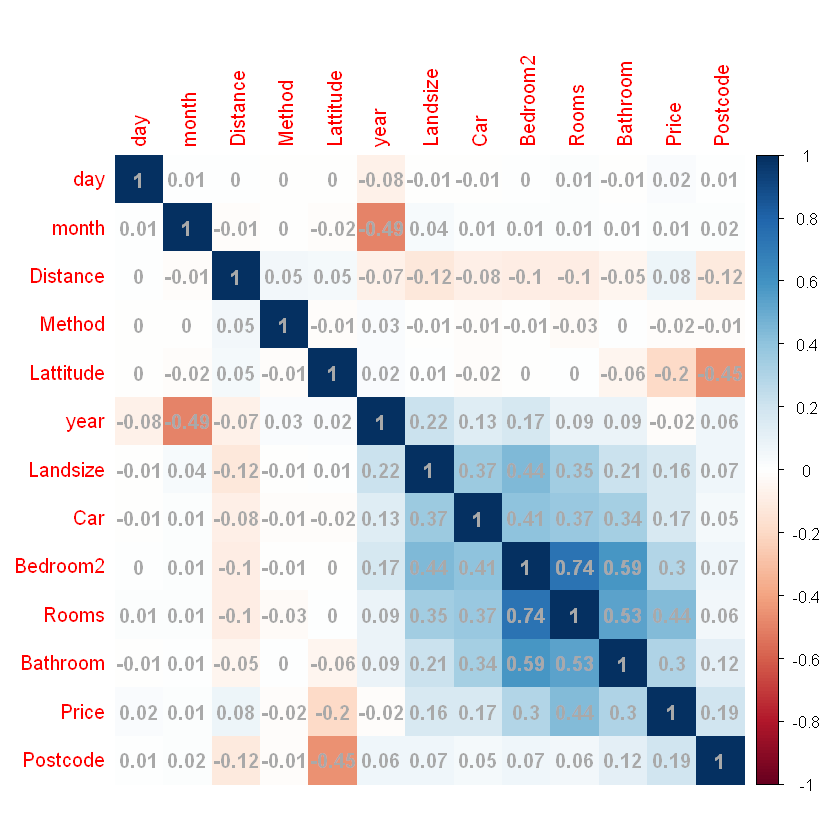

In [38]:
#### Corelation plot for the data. ###

corrplot(cor(Data[1:13]), method = "color", addCoef.col = "darkgray", order = "AOE")

In [39]:
### Predicting the values for test dataset. ###

test$TypePredicted <- predict(model, newdata = test)
head(test$TypePredicted)

[1] 1 1 2 2 1 1
Levels: 1 2 3

In [40]:
### Building Classification Table.###

tab <- table(test$Type, test$TypePredicted)
print(tab)

   
       1    2    3
  1 6824  360   15
  2  616 1603   13
  3  776  257   16


# This tells us that the average absolute difference between the observed values and the predicted values is 0.5465. The lower the value for the MAE the better a model is able to fit a dataset.

In [41]:
paste("Accuracy:", round((sum(diag(tab))/sum(tab))*100,2))

[1] "Accuracy: 80.56"

Warning message in roc.default(response = test$Type, predictor = factor(test$TypePredicted, :
"'response' has more than two levels. Consider setting 'levels' explicitly or using 'multiclass.roc' instead"Setting levels: control = 1, case = 2
Setting direction: controls < cases


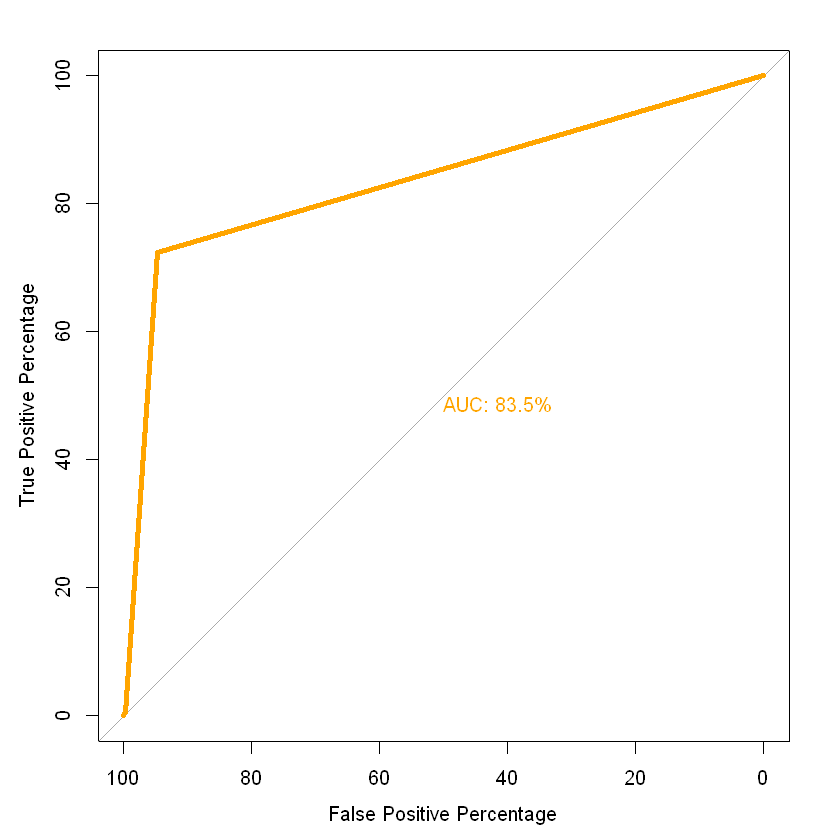

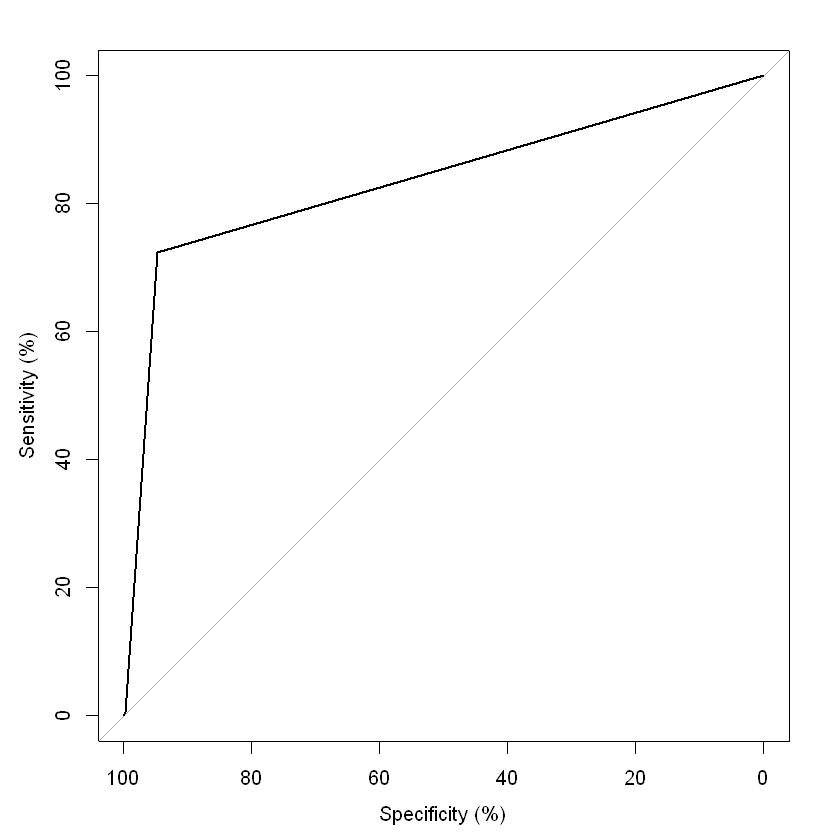

In [78]:
### ROC Curve to assess the diagnostic performance of a test. (Multinomial Logistic algorithm) by plotting TPRs and FPRs.###
library(pROC)
roc_object_multi <- roc(response=test$Type, predictor= factor(test$TypePredicted, ordered = TRUE), plot=TRUE, xlab="False Positive Percentage", ylab="True Positive Percentage", percent=TRUE, lwd=4, col="#FFA500",print.auc= TRUE)
plot(roc_object_multi)

# Multinomial Logistic Regression model has an accuracy score of 80.56%, hence it has classified all the house types as per the accuracy percentage. 

# Implementing Naive Bayes Classification algorithm to check the accuracy of the dataset.

In [51]:
model_nb <- naiveBayes(Type ~ ., data = train)
model_nb


Naive Bayes Classifier for Discrete Predictors

Call:
naiveBayes.default(x = X, y = Y, laplace = laplace)

A-priori probabilities:
Y
        1         2         3 
0.6883948 0.2077778 0.1038274 

Conditional probabilities:
   day
Y       [,1]     [,2]
  1 15.90293 8.306182
  2 15.69062 8.353848
  3 15.82813 8.259340

   month
Y       [,1]     [,2]
  1 7.175734 3.176331
  2 7.084699 3.124037
  3 7.016594 3.125397

   year
Y       [,1]      [,2]
  1 2016.868 0.6329065
  2 2016.760 0.6419853
  3 2016.824 0.6434247

   Rooms
Y       [,1]      [,2]
  1 3.350635 0.8456178
  2 2.017966 0.6539111
  3 2.914658 0.6902959

   Price
Y         [,1]      [,2]
  1  0.2552223 0.9814393
  2 -0.7523048 0.7415523
  3 -0.1271200 0.7901442

   Method
Y       [,1]     [,2]
  1 3.654252 1.926386
  2 3.878184 2.103176
  3 3.706045 2.081852

   Distance
Y          [,1]      [,2]
  1 -0.01218976 0.9867497
  2  0.13425177 1.0040334
  3 -0.09674328 1.0538166

   Postcode
Y       [,1]     [,2]
  1 84.10691 51.495

In [43]:
library(e1071)

In [52]:
pred_y <- predict(model_nb, newdata = test)

In [53]:
cm <- table(test$Type, pred_y)
cm

   pred_y
       1    2    3
  1 5859  795  545
  2  219 1758  255
  3  445  290  314

Warning message in roc.default(response = test$Type, predictor = factor(pred_y, :
"'response' has more than two levels. Consider setting 'levels' explicitly or using 'multiclass.roc' instead"Setting levels: control = 1, case = 2
Setting direction: controls < cases


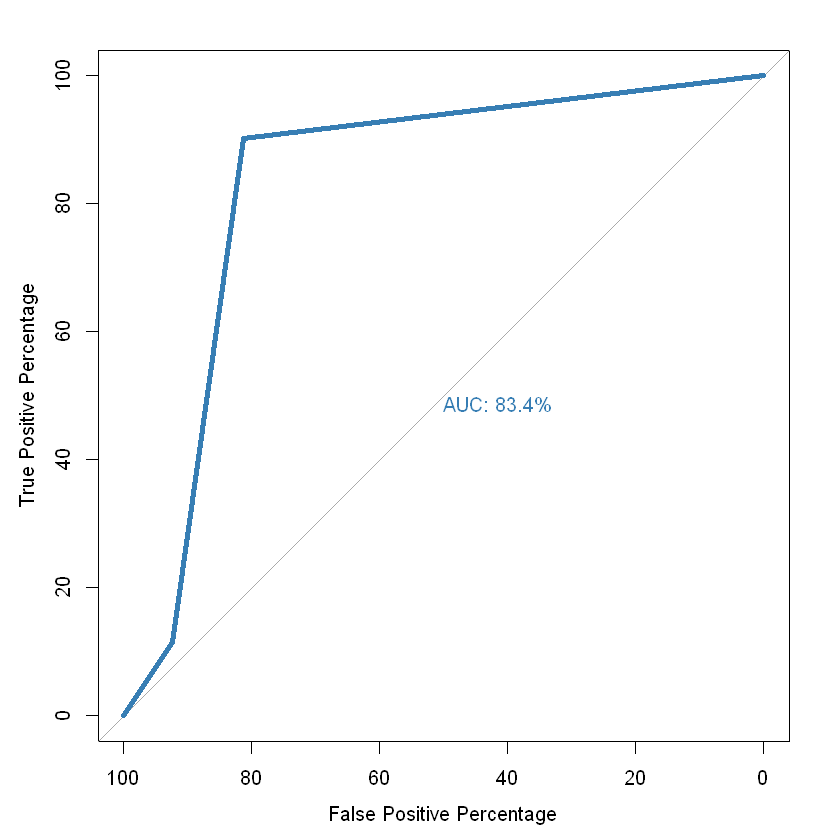

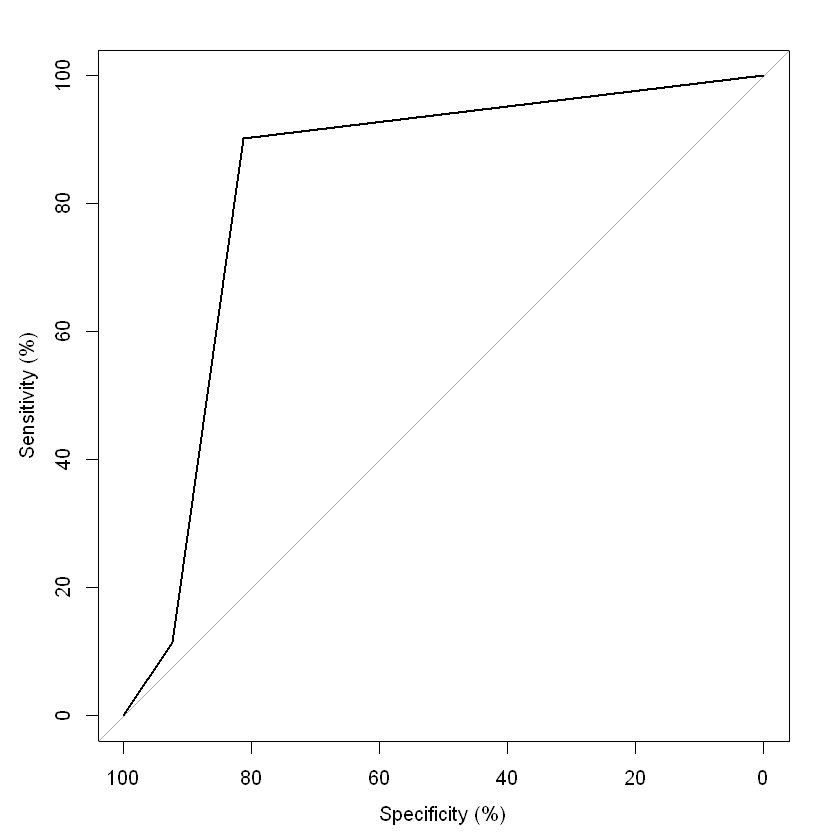

In [81]:
###ROC Curve to assess the diagnostic performance of a test. (Naive Bayes algorithm)
library(pROC)
roc_object_nb <- roc(response=test$Type, predictor= factor(pred_y, ordered = TRUE), plot=TRUE, xlab="False Positive Percentage",  ylab="True Positive Percentage", percent=TRUE, col="#377eb4", lwd=4, print.auc=TRUE)
plot(roc_object_nb)

In [58]:
table_1 <- table(test$Type, pred_y)
print(table_1)

   pred_y
       1    2    3
  1 5859  795  545
  2  219 1758  255
  3  445  290  314


In [59]:
#Calculate the Accuracy of Naive Bayes.
paste("Accuracy:", round((sum(diag(table_1))/sum(table_1))*100,2))

[1] "Accuracy: 75.68"

In [92]:
install.packages("ggplot2")

also installing the dependencies 'cli', 'lifecycle', 'rlang', 'scales', 'vctrs'




  There are binary versions available but the source versions are later:
          binary source needs_compilation
cli        2.5.0  3.4.1              TRUE
lifecycle  1.0.0  1.0.3             FALSE
rlang     0.4.11  1.0.6              TRUE
scales     1.1.1  1.2.1             FALSE
vctrs      0.3.8  0.5.1              TRUE
ggplot2    3.3.3  3.4.0             FALSE

  Binaries will be installed
package 'cli' successfully unpacked and MD5 sums checked
package 'rlang' successfully unpacked and MD5 sums checked
package 'vctrs' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Sarthak\AppData\Local\Temp\RtmpwlVFCN\downloaded_packages


installing the source packages 'lifecycle', 'scales', 'ggplot2'

Warning message in install.packages("ggplot2"):
"installation of package 'lifecycle' had non-zero exit status"Warning message in install.packages("ggplot2"):
"installation of package 'scales' had non-zero exit status"Warning message in install.packages("ggplot2"):
"installation of package 'ggplot2' had non-zero exit status"

# Naive Bayes model has an accuracy score of 75.68%, hence it has classified all the house types as per the accuracy percentage. 